# Clustering Validation with Entropy

Author: Simon Segert

Here I propose a simple way to measure the validity of a cluster. 

The key point is that good clusters tend to have several words that co-occur often. This indicates that the algorithm is picking up the context of the words. Conversely, bad clusters commonly have one word that dominates the frequency distribution, which leads to weird groupings  (the same word can be used in different ways in different contexts). So looking at the spread of the top few frequencies gives a reasonable measure of cluster quality. 



In [35]:
import pickle
with open('processed_10k_articles.pkl', 'rb') as pickle_file:
    data = pickle.load(pickle_file)


import pandas as pd
import numpy
import scipy

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

tfidf=TfidfVectorizer(min_df=.03, stop_words='english')
tfidf_matrix=tfidf.fit_transform(data['process'])

In [62]:
from IPython.core.display import HTML


In [36]:
len(tfidf.get_feature_names())

393

In [37]:
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=150).fit_predict(tfidf_matrix)


Some functions: 

In [8]:

def index_of_title(article_name, df):
    return df[df['title']==article_name].index.values[0]

#returns an array of clusters, with each cluster represented as an array of titles 
def get_cluster_titles(index_vector, titles): 
    cluster_titles=[]
    for i in range(max(index_vector)+1):
        cluster_titles.append([])
    
    for i in range(len(titles)):
        cluster_titles[index_vector[i]].append(titles[i])
    return cluster_titles

def get_lengths(index_vector): #return length of each cluster
    lengths=[]
    for i in range(max(index_vector)+1):
        lengths.append(0)
    for x in index_vector:
        lengths[x]+=1
    return lengths


def get_cm(cluster, feature_matrix, df): #return center of mass of cluster
    cm=[0]*len(feature_matrix[0, :].toarray())
    for title in cluster:
        cm=numpy.add(cm, feature_matrix[index_of_title(title, df), :].toarray()[0])
    return numpy.divide(cm, len(cluster))



def cluster_info(cluster, feature_matrix, feature_labels, df):#feature_labels normally=tfidf.get_feature_names()
    #print out the top terms at the cluster center
    
    cluster_mean = pd.DataFrame(index=range(feature_matrix.shape[1]),columns=['term','frequency'])
    cluster_mean['term']=feature_labels
    cluster_mean['frequency']=get_cm(cluster, feature_matrix, df)
    cluster_mean.sort_values('frequency',ascending=False,inplace=True)
    print(cluster_mean[0:10])

    #print out some titles
    print(cluster[0:21])
    
def get_max_freq(list_of_clusters, feature_matrix, df): #return top value of cluster_mean['frequency']
    return [max(get_cm(cluster, feature_matrix, df)) for cluster in list_of_clusters]

def get_entropy(cluster, feature_matrix, df): #return Shannon entropy of cluster
    cm=get_cm(cluster, feature_matrix, df)
    cm=-numpy.sort(-cm,)
    ent=scipy.stats.entropy(cm[0:4])
    if ent<-100:
        ent=0
    return ent

In [38]:
clusters=get_cluster_titles(kmeans, data['title'])

First let's take a look at a good cluster:

In [43]:
clusters[79]

['Monflanquin',
 'Ancy-le-Franc',
 'Annoux',
 'Archignat',
 'Autry-Issards',
 'Avermes',
 'Avrilly, Allier',
 'Viplaix',
 'Bellerive-sur-Allier',
 'Bézenet',
 'Billy, Allier',
 'Braize',
 'Le Brethon',
 'La Celle, Allier',
 'Chapeau, Allier',
 'Château-sur-Allier',
 'Deneuille-les-Mines',
 'Deux-Chaises',
 'Brion, Yonne',
 'Coutarnoux',
 'Garnat-sur-Engièvre',
 'Épineau-les-Voves',
 'Pont-sur-Yonne',
 'Gland, Yonne',
 "Gy-l'Évêque",
 'Précy-sur-Vrin',
 'Mélisey, Yonne',
 'Roffey, Yonne',
 'Montacher-Villegardin',
 'Les Ormes, Yonne',
 'Parly',
 'Paroy-sur-Tholon',
 'Sainte-Colombe-sur-Loing',
 'Saint-Léger-Vauban',
 'Sarry, Yonne',
 'Villeneuve-la-Dondagre',
 'Sens',
 'Talcy, Yonne',
 'Toucy',
 'Vaudeurs',
 'Vézelay',
 'Vézinnes',
 'Villecien',
 'Villebougis',
 'Montvicq',
 'Le Vilhain',
 'Louchy-Montfand',
 'Louroux-Hodement',
 'Mercy, Allier',
 'Maillet, Allier',
 'Magnet, Allier',
 'Périgny, Allier',
 'Rongères',
 'Saint-Marcel-en-Murat',
 'Saint-Pierre-Laval',
 "Saint-Priest-d'Ande

This seems to be mostly places in France (is it just me, or are there disproportionately many articles about obscure French villages?). The cluster_info bears this out:

In [44]:
cluster_info(clusters[79], tfidf_matrix, tfidf.get_feature_names(), data)

       term  frequency
92   depart   0.515089
74   commun   0.461086
128   franc   0.450318
56   center   0.439799
280   refer   0.197425
130  french   0.099689
301   saint   0.040567
178      la   0.015188
205     lot   0.008573
30     base   0.003639
['Monflanquin', 'Ancy-le-Franc', 'Annoux', 'Archignat', 'Autry-Issards', 'Avermes', 'Avrilly, Allier', 'Viplaix', 'Bellerive-sur-Allier', 'Bézenet', 'Billy, Allier', 'Braize', 'Le Brethon', 'La Celle, Allier', 'Chapeau, Allier', 'Château-sur-Allier', 'Deneuille-les-Mines', 'Deux-Chaises', 'Brion, Yonne', 'Coutarnoux', 'Garnat-sur-Engièvre']


We see that the terms 'commune', 'department', 'france' and 'center' all occur frequently (frequency>.4).  

Now let's look at a more questionable cluster:

In [76]:
clusters[87]

['Names of God in Islam',
 'Abdul Aziz Al Ghurair',
 'Motor neurone disease',
 'Resting potential',
 'Sura',
 'Ruby',
 'States of Sudan',
 "Ja'far",
 'Twelvers',
 'Musalla',
 'Imam Ali Mosque',
 'UAE Football League',
 'Ali Hassan al-Majid',
 'Ahmed Al Safi',
 "It's All About the Pentiums",
 'Absh Khatun',
 'Abd al-Rahman al-Sufi',
 'Neurolinguistic programming',
 'Samukh Rayon',
 'List of cities in Iraq',
 'List of cities in Qatar',
 'Eternal Silence',
 'Manuel De Sica',
 'Abu Anas al-Libi',
 'Mecca crane collapse',
 'Abu Ali al-Anbari',
 'Reem Al Numery',
 'Samia al-Amoudi']

This one looks at first like Arabic people and places, but there are a couple of articles like 'Motor neurone disease' that clearly don't belong. 

In [46]:
cluster_info(clusters[87], tfidf_matrix, tfidf.get_feature_names(), data)

        term  frequency
8         al   0.681178
280    refer   0.049443
363     unit   0.034290
22    associ   0.030768
96       die   0.029956
196     list   0.029915
90     death   0.029729
309  septemb   0.026907
117   famili   0.025432
222   mostli   0.025177
['Names of God in Islam', 'Abdul Aziz Al Ghurair', 'Motor neurone disease', 'Resting potential', 'Sura', 'Ruby', 'States of Sudan', "Ja'far", 'Twelvers', 'Musalla', 'Imam Ali Mosque', 'UAE Football League', 'Ali Hassan al-Majid', 'Ahmed Al Safi', "It's All About the Pentiums", 'Absh Khatun', 'Abd al-Rahman al-Sufi', 'Neurolinguistic programming', 'Samukh Rayon', 'List of cities in Iraq', 'List of cities in Qatar']


It seems that algorithm grouped all of these articles together based on the occurrence of 'al'. It makes sense that this would group together articles that contain a lot of Arabic names, but because of the stemming, it spuriously includes articles that have a lot of words that begin with 'al'. For example, 'Motor neuron disease' is also called 'ALS', which presumably after the stemming and lower-casing was rendered as 'al'. Similarly, rubies are aluminum oxide, so the 'Ruby' article has multiple words that start with 'al'. 


A lot of bad clusters tend to have lopsided frequency tables, like above. This is an indication that the algorithm is grouping together articles mainly on the basis of a single stem; the trouble with this is that a single word might be used differently in different articles, or even that different words (like aluminum and als) give the same stem. 

This problem didn't seem to be present in the first example, which I think is because the frequency distribution was "spread out" evenly over multiple words. Although two completely different articles can easily have a similar tfidf score for a single stem, it's very unlikely that two such articles will have similar scores for four different words. 


So one could measure the quality of a cluster by the 
<a href="https://simple.wikipedia.org/wiki/Information_entropy">Entropy</a> of the first few words in the frequency table. (I chose the first four). The lower the entropy, the more lopsided the distribution. 


Let's compute the entropy of each cluster:'

In [68]:
entropy=[get_entropy(cluster, tfidf_matrix, data) for cluster in clusters]

The entropy of the French villages cluster and the "Al" cluster are:

In [69]:
print(entropy[79], entropy[87])

1.38439673113 0.566946837558


The French cluster has higher entropy, indicating a more even distribution among the top words. 


Now consider the following cluster:

In [60]:
cluster_info(clusters[62], tfidf_matrix, tfidf.get_feature_names(), data)

        term  frequency
383     work   0.048932
351     time   0.043526
390     year   0.042342
192     life   0.034575
280    refer   0.033134
89       day   0.031381
339    studi   0.028048
110  english   0.027793
245    organ   0.026497
211     mani   0.025431
['Earth science', 'Time horizon', 'Thomm', 'Week', 'West', 'Thunder', 'Second International', 'John Belushi', 'Hunter S. Thompson', "Uncle John's Bathroom Reader", 'Richard Stallman', 'Organic chemistry', 'Aerospace engineering', 'Bauxite', 'Symptom', 'Saint Anna', 'Half-Life (video game)', 'Niagara Falls', 'Philipps University of Marburg', 'Anastacia', 'Little House on the Prairie']


This cluster has a very low maximum frequency of about .05, indicating that it's not really about anything in particular. However, when we compute the entropy, we get an artificially high value, because the function rescales the frequences to sum to 1. 

But this seems to be a fairly uncommon problem. For illustration, let's plot the histogram of the maximum frequency. 





In [63]:
max_freq=get_max_freq(clusters, tfidf_matrix, data)

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([  2.,   0.,   3.,   8.,  28.,  39.,  33.,  18.,  15.,   4.]),
 array([ 0.04893169,  0.12289798,  0.19686427,  0.27083056,  0.34479686,
         0.41876315,  0.49272944,  0.56669574,  0.64066203,  0.71462832,
         0.78859461]),
 <a list of 10 Patch objects>)

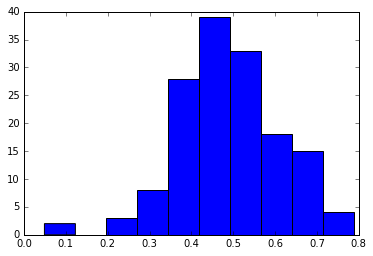

In [67]:
plt.hist(max_freq)

The vast majority of clusters have a maximum frequency between .3 and .6.

For comparison, here's the entropy histogram:

(array([  1.,   6.,   6.,  12.,  20.,  21.,  24.,  16.,  23.,  21.]),
 array([ 0.56694684,  0.64869183,  0.73043682,  0.81218181,  0.89392679,
         0.97567178,  1.05741677,  1.13916176,  1.22090675,  1.30265174,
         1.38439673]),
 <a list of 10 Patch objects>)

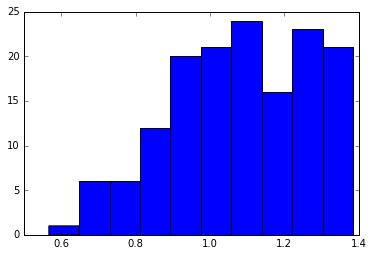

In [70]:
plt.hist(entropy)

A lot of clusters have problematically low entropy. Even for a value around 1, the distributions are pretty lopsided:

In [74]:
cluster_info(clusters[90], tfidf_matrix, tfidf.get_feature_names(), data)

        term  frequency
289  retriev   0.489239
71       com   0.083759
280    refer   0.073492
167  japanes   0.070645
196     list   0.068768
166    japan   0.067046
170     juli   0.048489
228   nation   0.047967
171     june   0.046311
373   websit   0.045107
['Giant salamander', 'Chinese calendar', 'Social status', 'UNetbootin', 'Mount Erebus', 'Vietnamese Wikipedia', 'Hysterotomy abortion', 'Shmuel Yosef Agnon', 'Pope Innocent VIII', 'Monsoon trough', 'Hiroshi Jofuku', 'All Sports Network', 'Nova Scotia Duck Tolling Retriever', 'Stroopwafel', 'St Kilda', 'Kosuke Fukudome', 'Oreo', 'Paraguay at the Olympics', 'Saint Vincent and the Grenadines at the Olympics', 'Alien hand syndrome', 'Stratovolcano']


In [75]:
entropy[90]

0.97345384677039437

Finally, based on empirical observation, it seems like the best clusters have 3-4 words that dominate the frequency distribution. So a rule of thumb for k vs. number of words (i.e., number of features in the tfidf matrix) might be 

(number of clusters)*(3 to 4)=number of words used 








